In [6]:
import math
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from datetime import datetime

steps 20000.0
batch_size 100
steps_per_period 2000.0
period 00: t: 264.26 v: 326.84
period 01: t: 263.03 v: 326.06
period 02: t: 262.28 v: 325.38
period 03: t: 261.59 v: 324.68
period 04: t: 260.89 v: 323.96
period 05: t: 260.20 v: 323.23
period 06: t: 259.49 v: 322.49
period 07: t: 258.79 v: 321.75
period 08: t: 258.08 v: 321.00
period 09: t: 257.38 v: 320.25
train_result_df
             target  train_prediction
count  10886.000000      10886.000000
mean     191.574132          8.698471
std      181.144454          0.379466
min        1.000000         -1.545596
25%       42.000000          8.730148
50%      145.000000          8.730148
75%      284.000000          8.730148
max      977.000000          8.730148
valid_result_df
             target  valid_prediction
count  10886.000000       5000.000000
mean     191.574132          8.729598
std      181.144454          0.033821
min        1.000000          6.371384
25%       42.000000          8.730148
50%      145.000000          8.7301

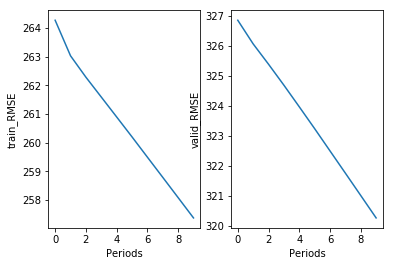

In [8]:
# %load multi_nn.py
import math
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from datetime import datetime

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
df = pd.read_csv('./data/bike_train.csv')
df['target'] = df['count']

df.describe()



def get_days_of_year(date):
    date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    new_year_day = datetime(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1


df['day_of_year'] = df['datetime'].apply(get_days_of_year)
df['hour'] = df['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour)
df['workday'] = df['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday())

df.columns

# 1. Define target and features
# - Define features and configure feature columns
# - Define the target
# - Define the input function.

# 2. Define the model
# - Configure the linear regression
# - Train the model

# 3. Evalute the model.
# - Predict
# - Measure score.


def preprcoess_features(src_df, feature_labels):
    df = src_df[feature_labels].copy()
    return df


def preprocess_target(src_df, target_label):
    df = pd.DataFrame()
    df['target'] = src_df[target_label] #/ 1000.0
    return df


def get_feature_columns(feature_labels):
    return set([
        tf.feature_column.numeric_column(feature_label)
        for feature_label in feature_labels
    ])


# get_feature_columns(feature_labels)


def input_fn(X_data,
             y_data,
             batch_size=1,
             repeat=1,
             shuffle=False):
    X_tensor = {key: np.array(value) for key, value in dict(X_data).items()}
    y_tensor = y_data
    ds = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))
    ds = ds.batch(int(batch_size)).repeat(repeat)
    if shuffle:
        ds = ds.shuffle(10000)
    X, y = ds.make_one_shot_iterator().get_next()
    return X, y


def train_model(hidden_units=[3],
                learning_rate=1e-4,
                steps=10,
                batch_size=1,
                feature_labels=['hour'],
                target_label='count',
                repeat=1):

    # hidden_units=[3]
    # learning_rate=1e-4
    # steps=10000
    # batch_size=100
    # feature_labels=['population']
    # target_label='median_house_value'
    # repeat=None

    periods = 10
    steps_per_period = steps / periods

    print('steps', steps)
    print('batch_size', batch_size)
    print('steps_per_period', steps_per_period)

    X_train = preprcoess_features(df.head(12000), feature_labels)
    y_train = preprocess_target(df.head(12000), target_label)

    X_valid = preprcoess_features(df.tail(5000), feature_labels)
    y_valid = preprocess_target(df.tail(5000), target_label)

    train_input_fn = lambda: input_fn(X_train, y_train, batch_size=batch_size, repeat=repeat, shuffle=True)
    predict_train_input_fn = lambda: input_fn(X_train, y_train, batch_size=1, repeat=1, shuffle=False)
    predict_valid_input_fn = lambda: input_fn(X_valid, y_valid, batch_size=1, repeat=1, shuffle=False)

    # Define the model
    # - configure liner regression
    #   - configure optimizer
    #   - choose algorithmn
    # - train the model

    gopt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    gopt = tf.contrib.estimator.clip_gradients_by_norm(gopt, 5.0)

    dnn_regressor = tf.estimator.DNNRegressor(
        hidden_units=hidden_units,
        feature_columns=get_feature_columns(feature_labels),
        optimizer=gopt)

    train_RMSEs = []
    valid_RMSEs = []

    for period in range(0, periods):
        dnn_regressor.train(input_fn=train_input_fn, steps=steps_per_period)

        train_predictions = dnn_regressor.predict(
            input_fn=predict_train_input_fn)
        train_predictions = [
            item['predictions'][0] for item in train_predictions
        ]
        train_mean_squared_error = metrics.mean_squared_error(
            y_train, train_predictions)
        train_RMSE = math.sqrt(train_mean_squared_error)
        train_RMSEs.append(train_RMSE)

        valid_predictions = dnn_regressor.predict(
            input_fn=predict_valid_input_fn)
        valid_predictions = [
            item['predictions'][0] for item in valid_predictions
        ]
        valid_mean_squard_error = metrics.mean_squared_error(
            y_valid, valid_predictions)
        valid_RMSE = math.sqrt(valid_mean_squard_error)
        valid_RMSEs.append(valid_RMSE)

        print("period %02d: t: %0.2f v: %0.2f" % (period, train_RMSE,
                                                  valid_RMSE))

    plt.subplot(1, 2, 1)
    plt.xlabel('Periods')
    plt.ylabel('train_RMSE')
    plt.plot(np.arange(len(train_RMSEs)), train_RMSEs)

    plt.subplot(1, 2, 2)
    plt.xlabel('Periods')
    plt.ylabel('valid_RMSE')
    plt.plot(np.arange(len(valid_RMSEs)), valid_RMSEs)

    print('train_result_df')
    train_result_df = pd.DataFrame({
        "train_prediction": pd.Series(train_predictions),
        "target": df["target"]
    })
    print(train_result_df.describe())

    print('valid_result_df')
    valid_result_df = pd.DataFrame({
        "valid_prediction": pd.Series(valid_predictions),
        "target": df["target"]
    })
    print(valid_result_df.describe())
    print("RMSE t: %0.2f v: %0.df" % (train_RMSE, valid_RMSE))

    plt.show()


train_model(
    hidden_units=[3, 3],
    learning_rate=1e-4,
    steps=2e+4,
    batch_size=100,
    feature_labels=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'target', 'day_of_year', 'hour', 'workday'],
    repeat=None
)


In [ ]:
train_model(
    hidden_units=[3, 3],
    learning_rate=1e-3,
    steps=2e+6,
    batch_size=100,
    feature_labels=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'target', 'day_of_year', 'hour', 'workday'],
    repeat=None
)

In [ ]:
train_model(
    hidden_units=[10, 10],
    learning_rate=1e-3,
    periods=1000,
    steps=2e+6,
    batch_size=100,
    feature_labels=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'day_of_year', 'hour', 'workday'],
    repeat=None
)
